In [2]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Restructuring data to get self-loop details 

In [4]:
path = "C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project"

In [16]:
file_ = open(os.path.join(path,"data/json_data.json"))

In [18]:
data_dic = json.load(file_)

In [80]:
def restructure_data(data_dic):
    cols_df2 = data_dic['nodes'] +['selfloop']
    cols_df1 = ['car-id', 'car_type', 'enter_date', 'exit_date', 'total_in_time']
    df1 = pd.DataFrame(columns=cols_df1)
    df2 = pd.DataFrame(columns=cols_df2)

    for cartype in data_dic['data'].keys():
        for car in data_dic['data'][cartype]:
            col_1 = list(car.values())
            del col_1[1]
            df1.loc[len(df1)] = col_1
            col_2 =[0]*len(cols_df2)  
            for path in car['path_taken']:
                start = list(path.keys())[0].split(" ")[0]
                end = list(path.keys())[0].split(" ")[-1]
                if start == end:
                    col_2[cols_df2.index(end)] = list(path.values())[0]
                    col_2[-1] +=1  
            df2.loc[len(df2)] = col_2
    return pd.concat((df1,df2),axis=1)

In [81]:
df_new = restructure_data(data_dic)

In [166]:
df_new.to_csv(os.path.join(path,"data/selploop.csv"))

# Distribution plots

In [156]:
total_time_stayed_at_a_node = []
for colname in df_new.columns[5:14]:
    total_time_stayed_at_a_node.append(np.sum(df_new[colname]))

In [157]:
y = np.array(total_time_stayed_at_a_node)/(60*24)
x=  df_new.columns[5:14] 

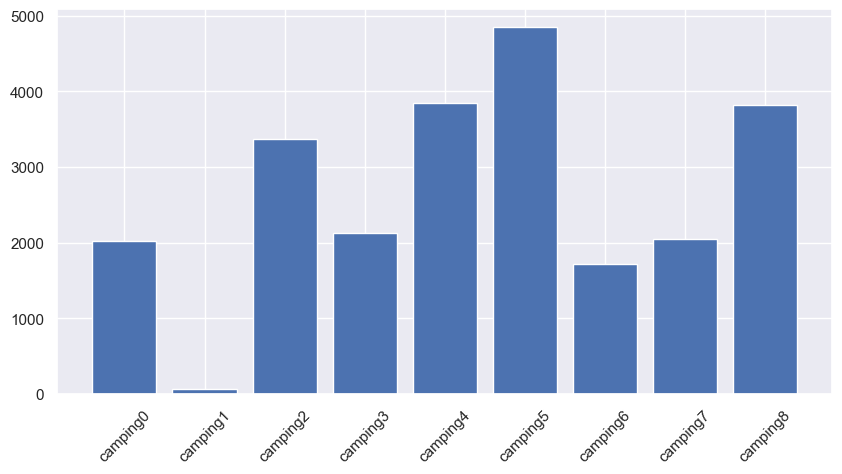

In [158]:
fig = plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.xticks(rotation=45)
plt.show()

In [159]:
total_time_stayed_at_a_node = []
for colname in df_new.columns[14:-1]:
    total_time_stayed_at_a_node.append(np.sum(df_new[colname]))

In [160]:
x = df_new.columns[14:-1]
y = np.array(total_time_stayed_at_a_node)/60

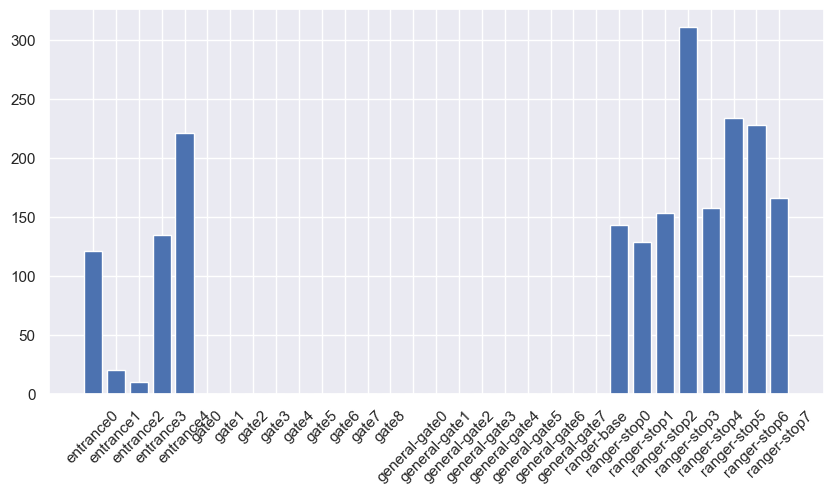

In [161]:
fig = plt.figure(figsize=(10,5))
plt.bar(x,y)
plt.xticks(rotation=45)
plt.show()

# Heatmap of camping sites

* Values represent the average time spend at camping site.
* Color represents the number of cars that stayed at the camping sites

In [5]:
df = pd.read_csv(os.path.join(path,"data/selploop.csv"),index_col=0)

C:\Users\18565\AppData\Local\Temp\ipykernel_17208\591559893.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path,"data/selploop.csv"),index_col=0)


In [11]:
df['car_type'] = df['car_type'].astype("str")

In [13]:
df['enter_date'] = pd.to_datetime(df['enter_date'])

In [14]:
df['month_year'] = df['enter_date'].dt.strftime('%y-%m')

In [15]:
np.unique(df['month_year'])

array(['15-05', '15-06', '15-07', '15-08', '15-09', '15-10', '15-11',
       '15-12', '16-01', '16-02', '16-03', '16-04', '16-05'], dtype=object)

In [59]:
def get_heatmap_data(df,cat):
    colors = []
    values = []
    vmin = np.inf
    vmax = -np.inf
    for colname in df.columns:
        if cat in colname:
            heat_map_values = df.pivot_table(index="month_year",columns="car_type",
                                  values=colname, aggfunc='sum', fill_value=0)
            heat_map_colors = df.pivot_table(index="month_year",columns="car_type",
                                  values=colname, aggfunc='nunique', fill_value=0)
            heat_map_colors.replace(1,0,inplace=True)
            heat_map_avg_values = heat_map_values/heat_map_colors
            heat_map_avg_values.fillna(0,inplace=True)
            if np.max(heat_map_colors) > vmax:
                vmax = np.max(heat_map_colors)
            if np.min(heat_map_colors) < vmin:
                vmin = np.min(heat_map_colors)
            colors.append(heat_map_colors)
            values.append(heat_map_avg_values)
    return colors,values,vmin,vmax
            
            
            
    

In [69]:
colors,values,vmin,vmax = get_heatmap_data(df,'camping')

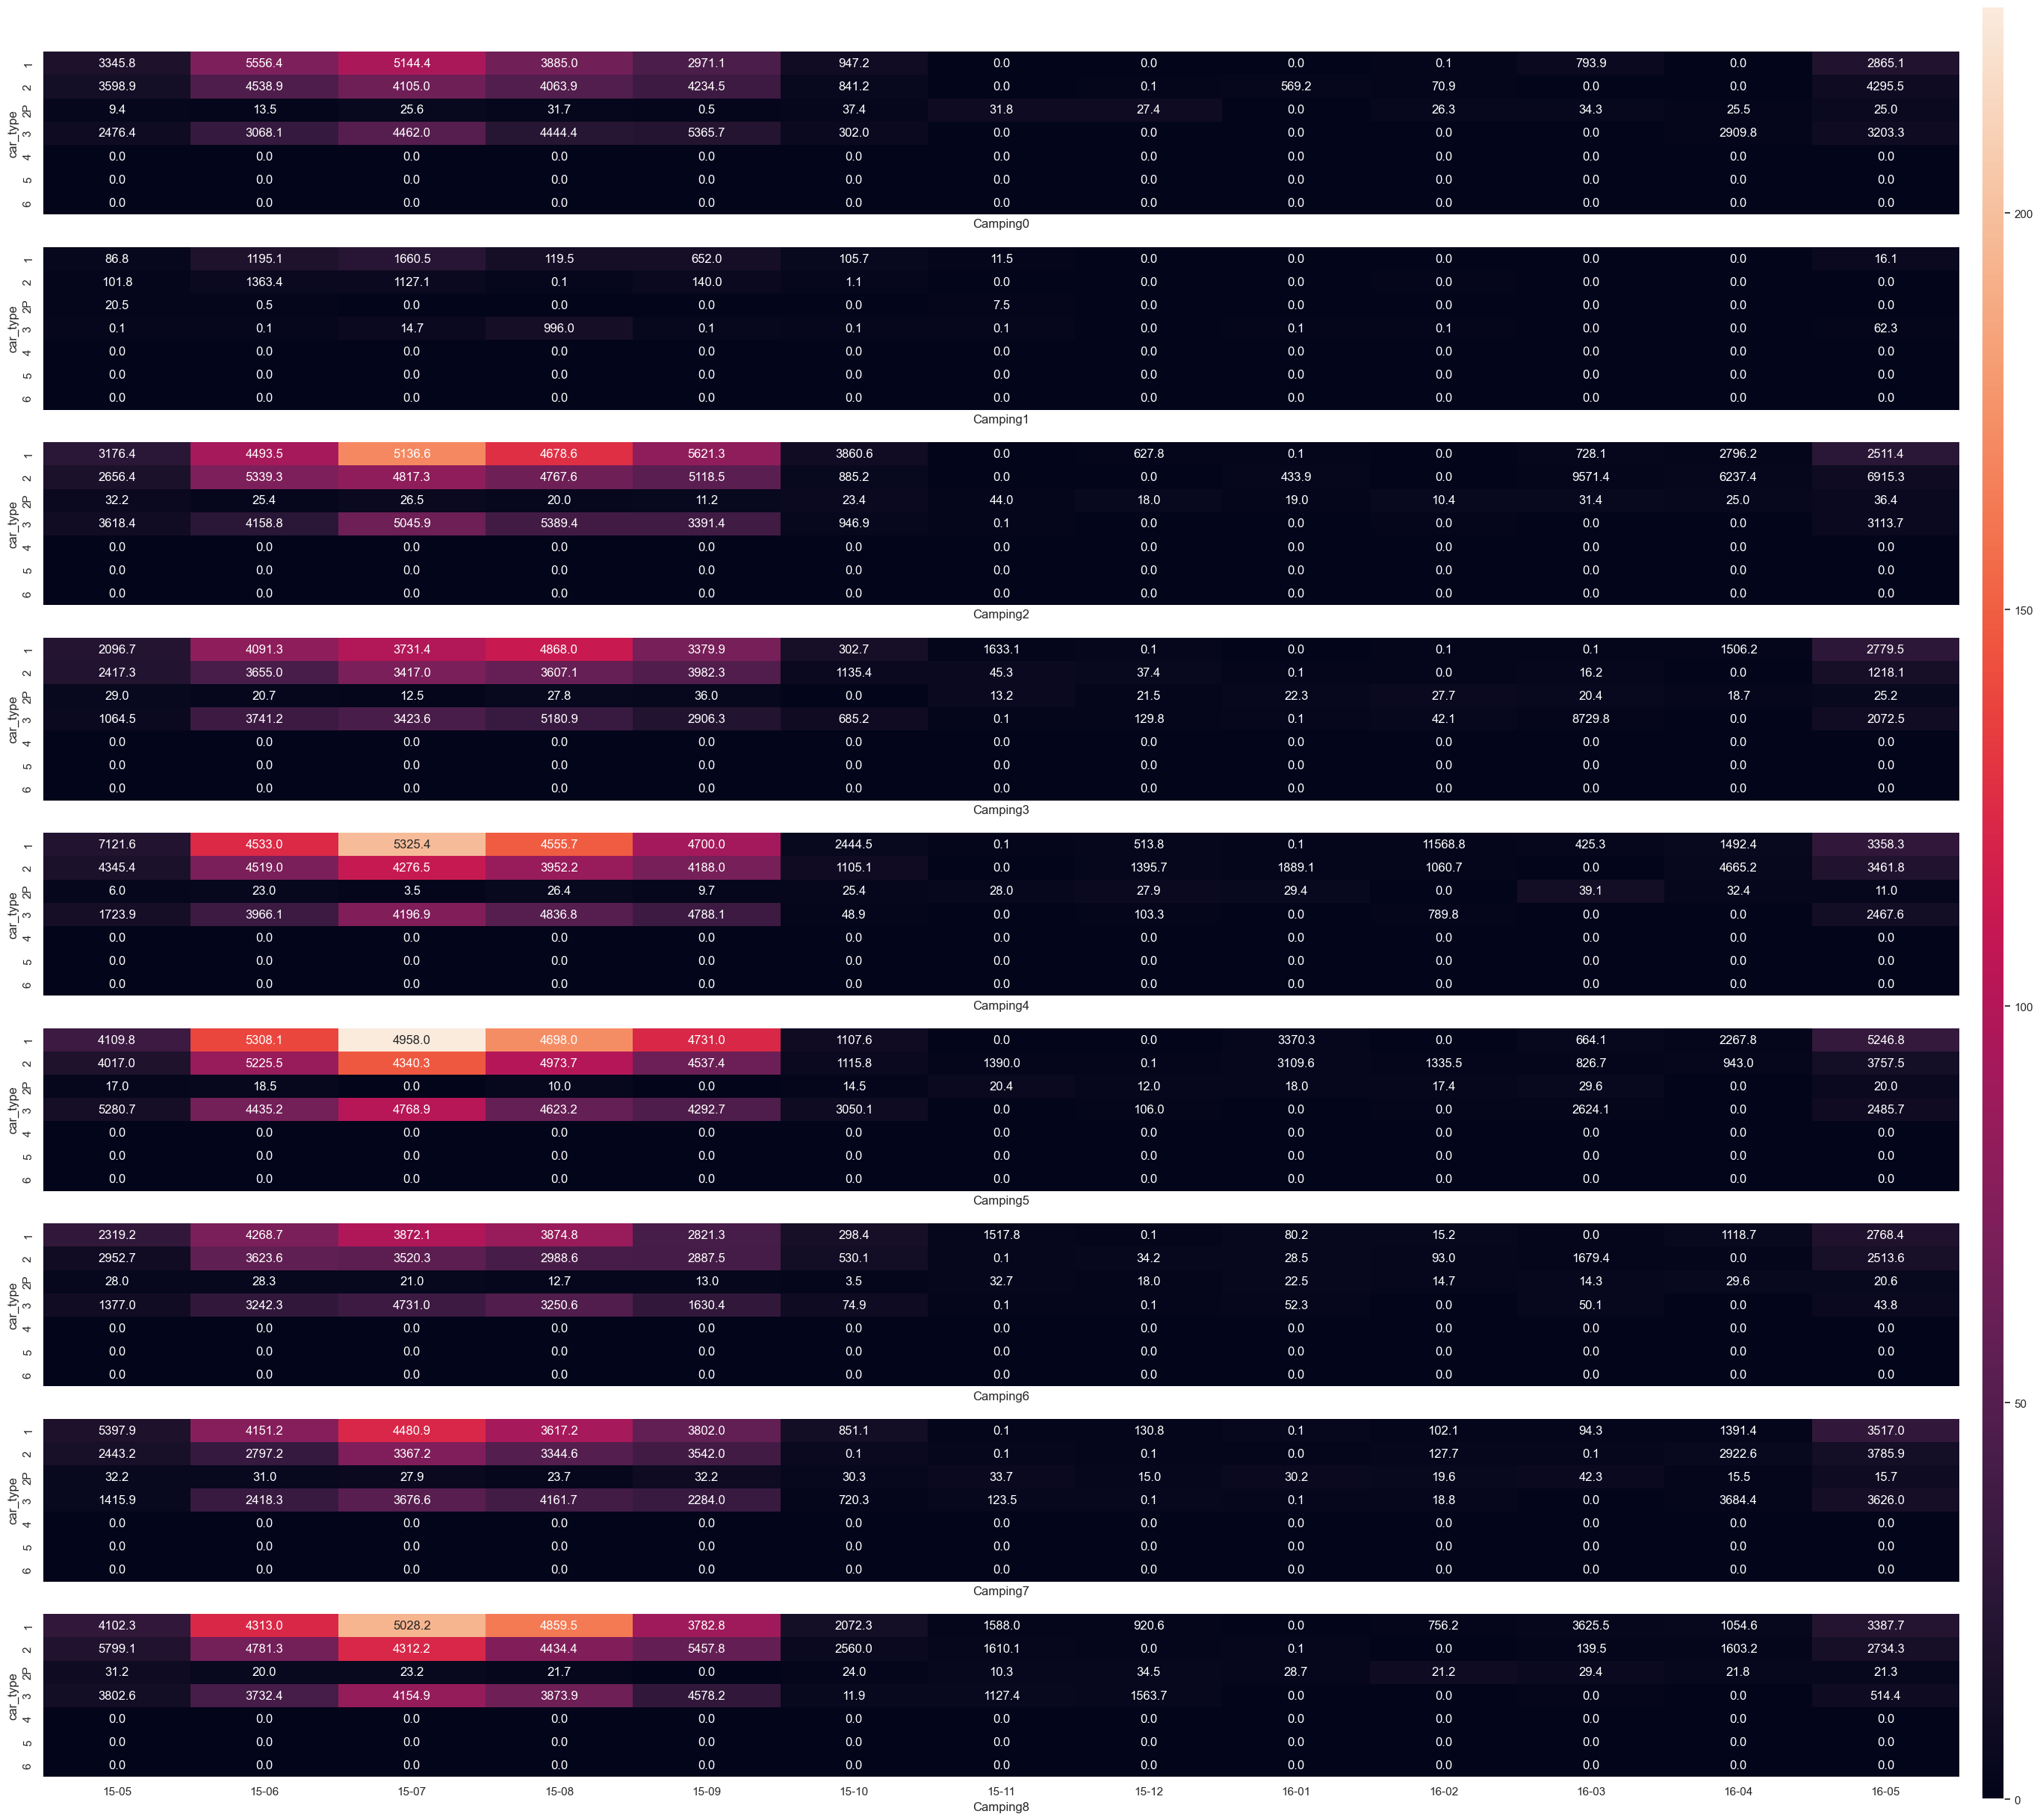

In [97]:
fig, axs = plt.subplots(len(colors),1,figsize=(30,30))
count = 0
for ax, color, value in zip(axs,colors,values):
    sns.heatmap(color.T,annot=value.T,fmt='.1f',ax=ax, vmin=vmin,vmax=vmax,cbar=False)
    if count <8:
        ax.xaxis.set_tick_params(labelbottom=False,which='both')
    ax.set(xlabel="Camping"+str(count))
    count+=1
fig.subplots_adjust(right=0.98)
cbar_ax = fig.add_axes([0.99, 0.1, 0.01, 0.8])
fig.colorbar(ax.collections[0],cax=cbar_ax)

plt.show()